# Advanced Crop Price Prediction with Gradio Interface
Complete analysis with Random Forest, XGBoost, LightGBM models and interactive web interface

## Install Required Libraries

In [1]:
%pip install xgboost lightgbm scikit-learn matplotlib seaborn pandas numpy gradio -q

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [2]:
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
import gradio as gr

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

/Users/macbook/Documents/GitHub/crop-prediction/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All libraries imported successfully


## Load and Prepare Data

In [5]:
# Load the dataset
df = pd.read_csv('/Users/macbook/Documents/GitHub/crop-prediction/dataset/anshtanwar/current-daily-price-of-various-commodities-india/Price_Agriculture_commodities_Week.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nFirst few rows:")
display(df.head())

print(f"\nDataset Info:")
print(df.info())

print(f"\nBasic Statistics:")
display(df.describe())

Dataset Shape: (23093, 10)

First few rows:


,State,District,Market,Commodity,Variety,Grade,Arrival_Date,Min Price,Max Price,Modal Price
0,Gujarat,Amreli,Damnagar,Bhindi(Ladies Finger),Bhindi,FAQ,27-07-2023,4100.0,4500.0,4350.0
1,Gujarat,Amreli,Damnagar,Brinjal,Other,FAQ,27-07-2023,2200.0,3000.0,2450.0
2,Gujarat,Amreli,Damnagar,Cabbage,Cabbage,FAQ,27-07-2023,2350.0,3000.0,2700.0
3,Gujarat,Amreli,Damnagar,Cauliflower,Cauliflower,FAQ,27-07-2023,7000.0,7500.0,7250.0
4,Gujarat,Amreli,Damnagar,Coriander(Leaves),Coriander,FAQ,27-07-2023,8400.0,9000.0,8850.0



Dataset Info:
<class 'pandas.DataFrame'>
RangeIndex: 23093 entries, 0 to 23092
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         23093 non-null  str    
 1   District      23093 non-null  str    
 2   Market        23093 non-null  str    
 3   Commodity     23093 non-null  str    
 4   Variety       23093 non-null  str    
 5   Grade         23093 non-null  str    
 6   Arrival_Date  23093 non-null  str    
 7   Min Price     23093 non-null  float64
 8   Max Price     23093 non-null  float64
 9   Modal Price   23093 non-null  float64
dtypes: float64(3), str(7)
memory usage: 1.8 MB
None

Basic Statistics:


,Min Price,Max Price,Modal Price
count,23093.000000,23093.000000,23093.000000
mean,4187.077045,4976.034260,4602.917742
std,5472.783385,6277.308057,5843.822711
min,0.000000,0.000000,0.830000
25%,1750.000000,2000.000000,1955.000000
50%,2725.000000,3400.000000,3000.000000
75%,5000.000000,6000.000000,5500.000000
max,223500.000000,227500.000000,225500.000000


In [6]:
# Data Cleaning and Preparation
df['Arrival_Date'] = pd.to_datetime(df['Arrival_Date'], format='%d-%m-%Y', errors='coerce')

# Extract date features
df['year'] = df['Arrival_Date'].dt.year
df['month'] = df['Arrival_Date'].dt.month
df['day'] = df['Arrival_Date'].dt.day
df['day_of_week'] = df['Arrival_Date'].dt.dayofweek
df['quarter'] = df['Arrival_Date'].dt.quarter
df['week_of_year'] = df['Arrival_Date'].dt.isocalendar().week

# Convert price columns to numeric
for col in ['Min Price', 'Max Price', 'Modal Price']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create price range feature
df['Price_Range'] = df['Max Price'] - df['Min Price']

# Remove rows with missing critical values
df_clean = df.dropna(subset=['Modal Price', 'Arrival_Date']).copy()

print(f"\nCleaned Dataset Shape: {df_clean.shape}")
print(f"Missing values per column:")
print(df_clean.isnull().sum())

print(f"\nDate Range: {df_clean['Arrival_Date'].min()} to {df_clean['Arrival_Date'].max()}")
print(f"Total Commodities: {df_clean['Commodity'].nunique()}")
print(f"Total States: {df_clean['State'].nunique()}")


Cleaned Dataset Shape: (23093, 17)
Missing values per column:
State           0
District        0
Market          0
Commodity       0
Variety         0
Grade           0
Arrival_Date    0
Min Price       0
Max Price       0
Modal Price     0
year            0
month           0
day             0
day_of_week     0
quarter         0
week_of_year    0
Price_Range     0
dtype: int64

Date Range: 2023-07-27 00:00:00 to 2023-08-02 00:00:00
Total Commodities: 234
Total States: 27


## Exploratory Data Analysis

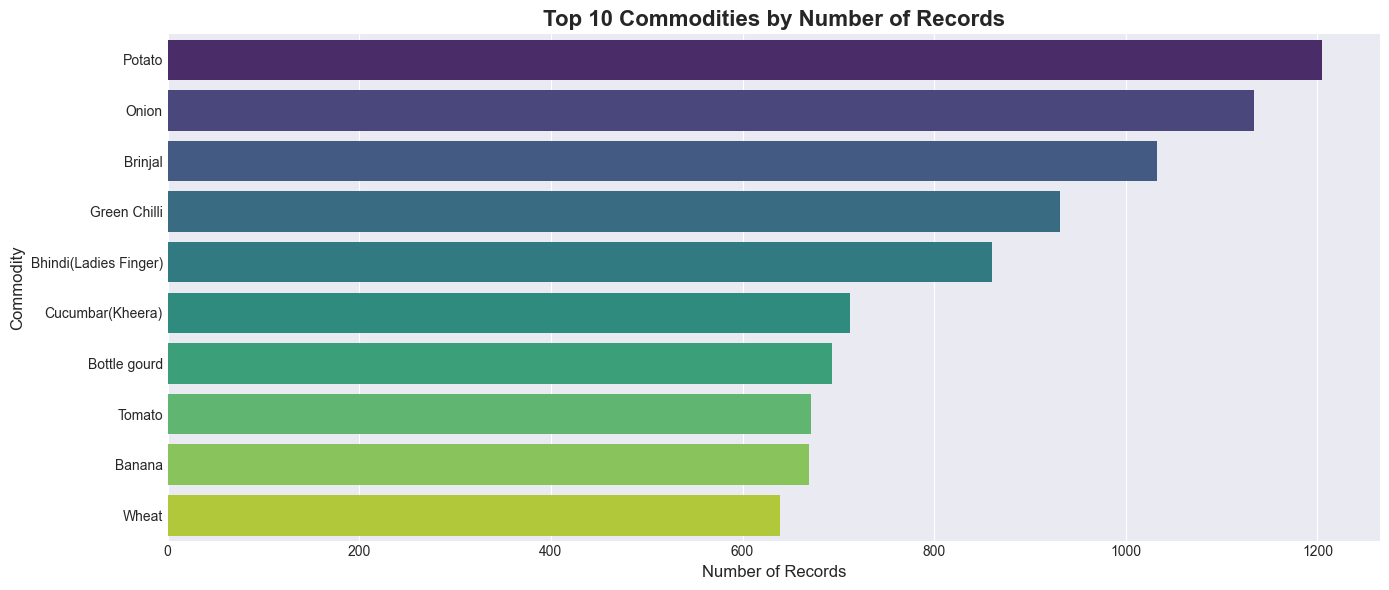

Top 10 Commodities:
Commodity
Potato                   1205
Onion                    1134
Brinjal                  1033
Green Chilli              931
Bhindi(Ladies Finger)     860
Cucumbar(Kheera)          712
Bottle gourd              693
Tomato                    671
Banana                    669
Wheat                     639
Name: count, dtype: int64


In [7]:
# Top 10 Commodities by Number of Records
plt.figure(figsize=(14, 6))
top_commodities = df_clean['Commodity'].value_counts().head(10)
sns.barplot(x=top_commodities.values, y=top_commodities.index, palette='viridis')
plt.title('Top 10 Commodities by Number of Records', fontsize=16, fontweight='bold')
plt.xlabel('Number of Records', fontsize=12)
plt.ylabel('Commodity', fontsize=12)
plt.tight_layout()
plt.show()

print("Top 10 Commodities:")
print(top_commodities)

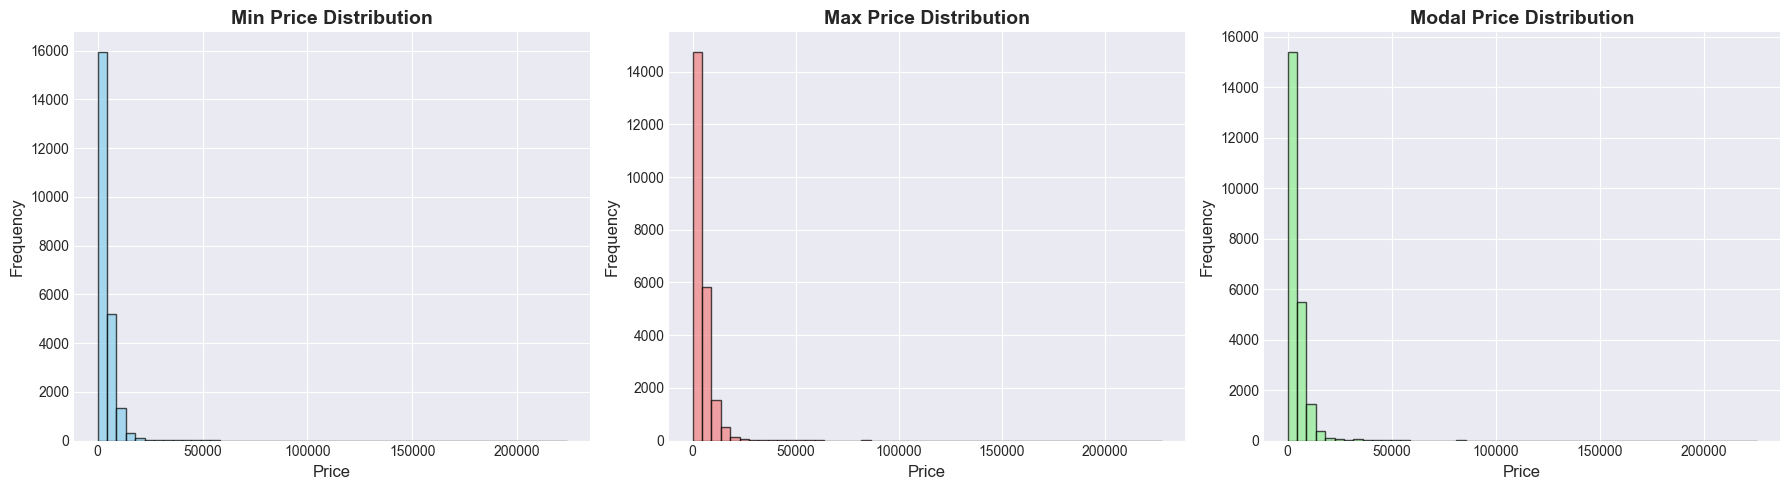

In [8]:
# Price Distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(df_clean['Min Price'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Min Price Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Price', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

axes[1].hist(df_clean['Max Price'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_title('Max Price Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Price', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

axes[2].hist(df_clean['Modal Price'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].set_title('Modal Price Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Price', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

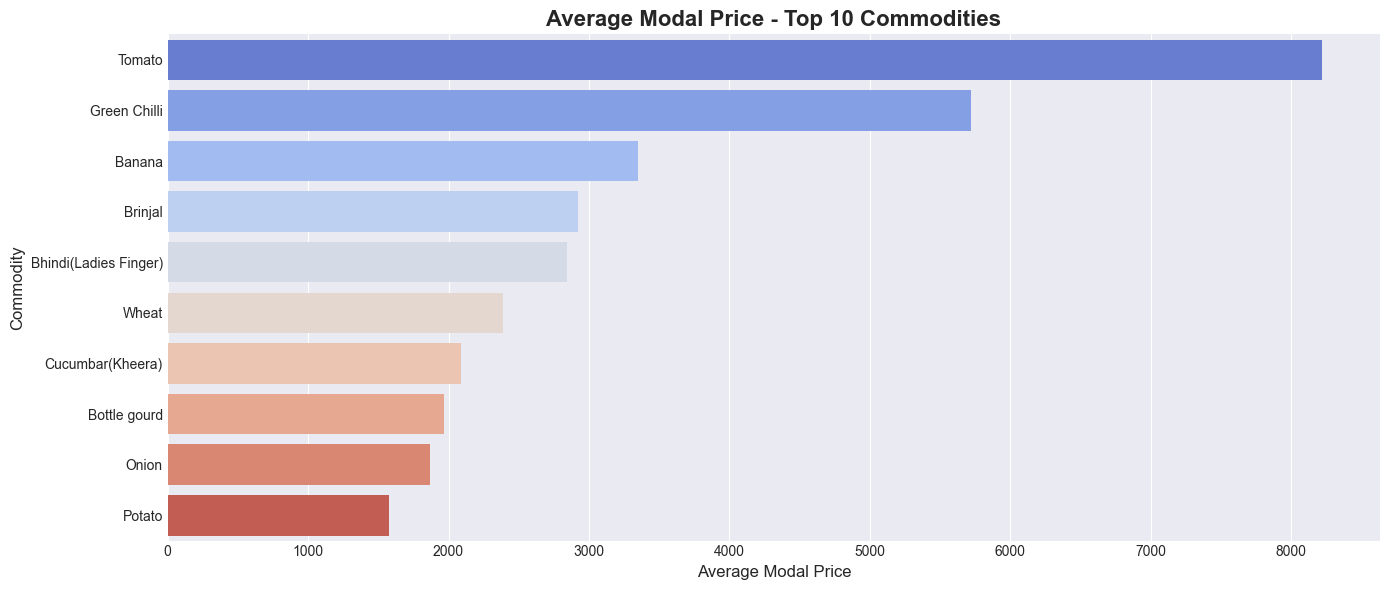

In [9]:
# Average Modal Price by Top 10 Commodities
top_10_commodities = df_clean['Commodity'].value_counts().head(10).index
avg_prices = df_clean[df_clean['Commodity'].isin(top_10_commodities)].groupby('Commodity')['Modal Price'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=avg_prices.values, y=avg_prices.index, palette='coolwarm')
plt.title('Average Modal Price - Top 10 Commodities', fontsize=16, fontweight='bold')
plt.xlabel('Average Modal Price', fontsize=12)
plt.ylabel('Commodity', fontsize=12)
plt.tight_layout()
plt.show()

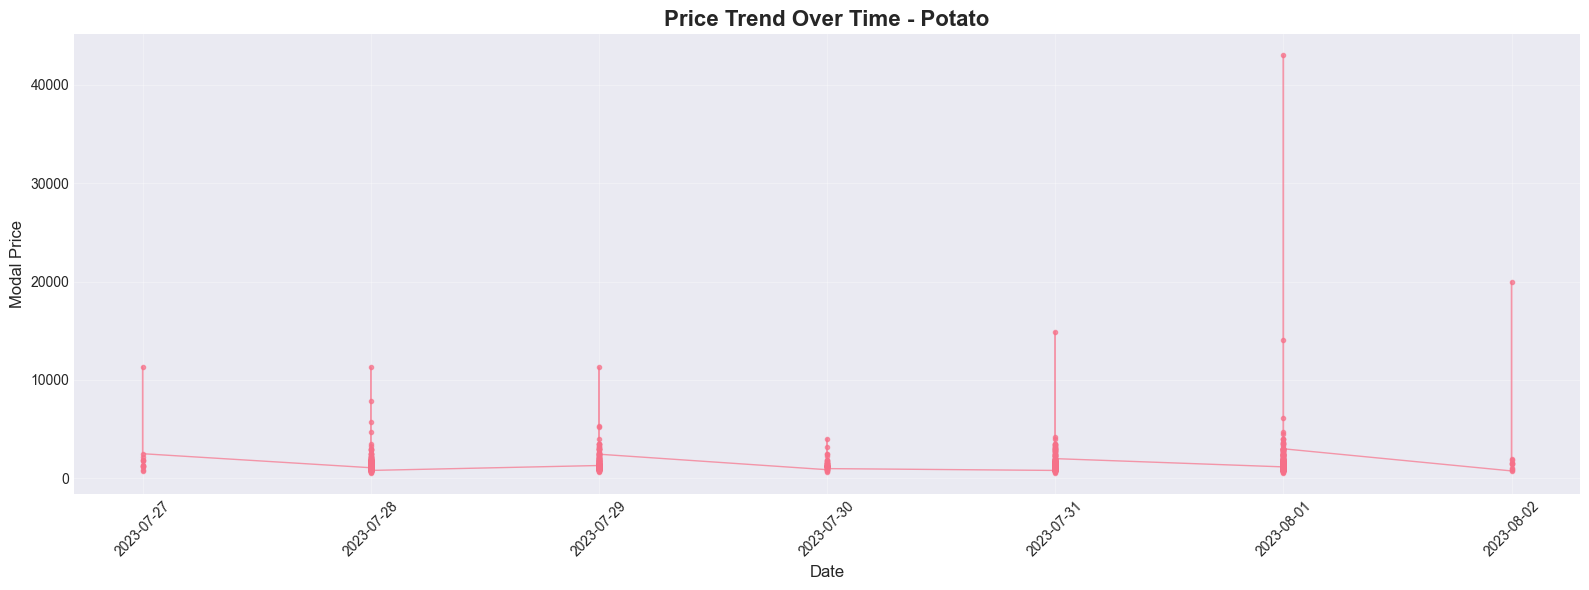

In [10]:
# Price Trends Over Time (for top commodity)
top_commodity = df_clean['Commodity'].value_counts().index[0]
commodity_data = df_clean[df_clean['Commodity'] == top_commodity].sort_values('Arrival_Date')

plt.figure(figsize=(16, 6))
plt.plot(commodity_data['Arrival_Date'], commodity_data['Modal Price'], marker='o', markersize=3, linewidth=1, alpha=0.7)
plt.title(f'Price Trend Over Time - {top_commodity}', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Modal Price', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

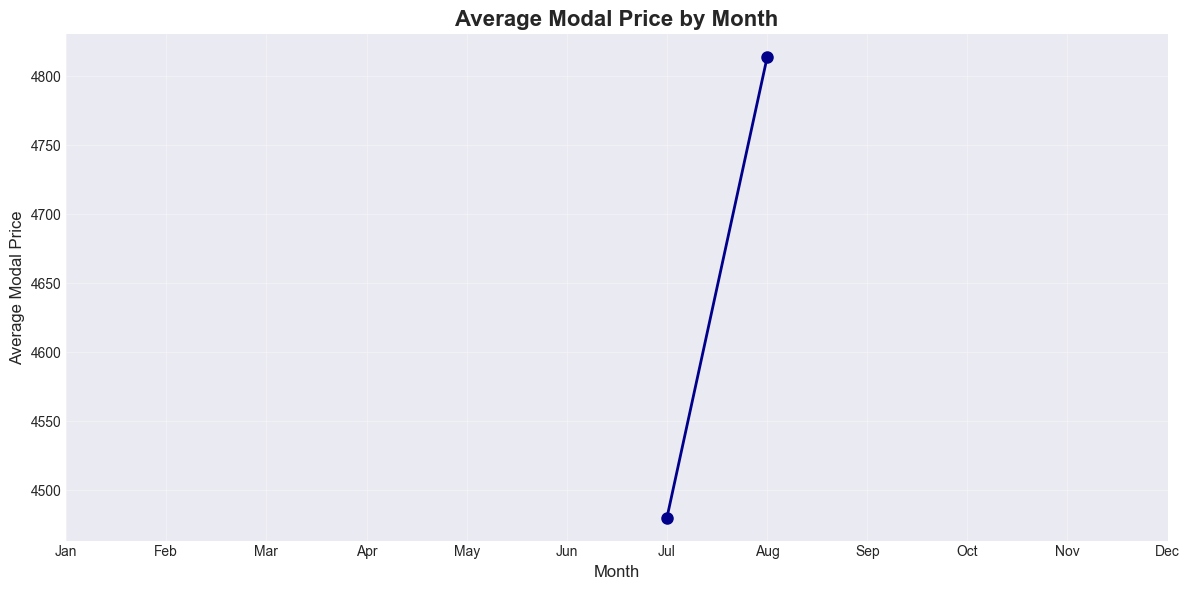

In [11]:
# Monthly Average Prices
monthly_avg = df_clean.groupby('month')['Modal Price'].mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, markersize=8, color='darkblue')
plt.title('Average Modal Price by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Modal Price', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

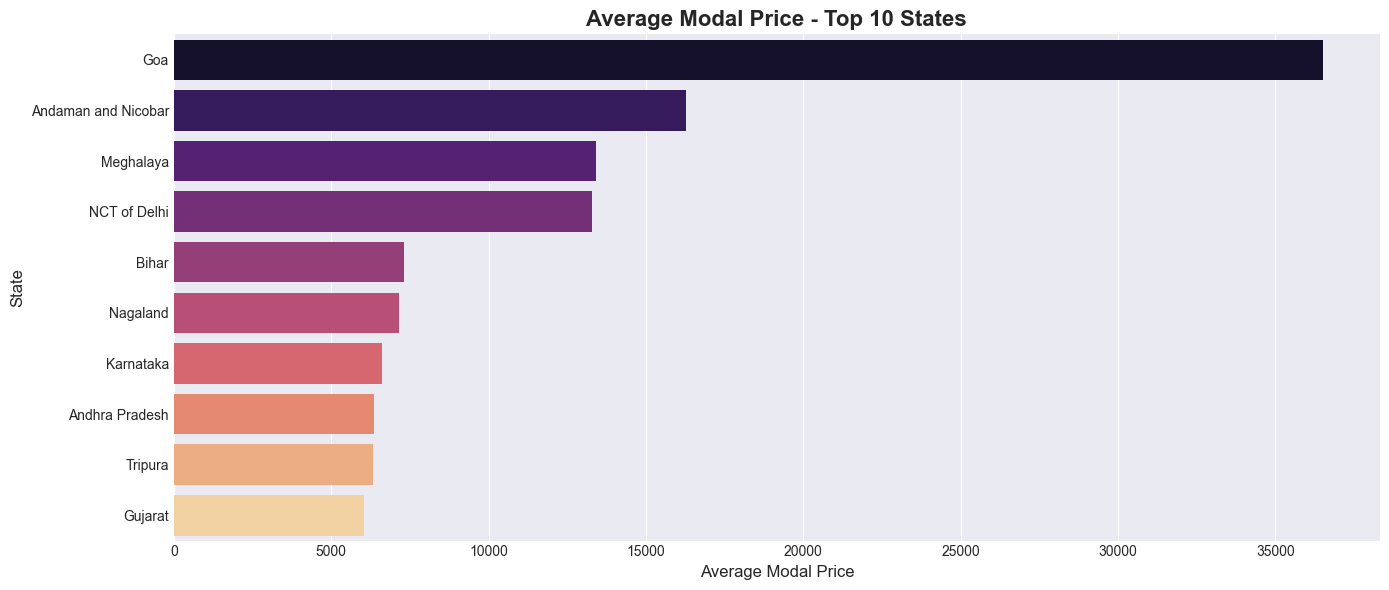

In [12]:
# State-wise Average Prices (Top 10 States)
state_avg = df_clean.groupby('State')['Modal Price'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 6))
sns.barplot(x=state_avg.values, y=state_avg.index, palette='magma')
plt.title('Average Modal Price - Top 10 States', fontsize=16, fontweight='bold')
plt.xlabel('Average Modal Price', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.tight_layout()
plt.show()

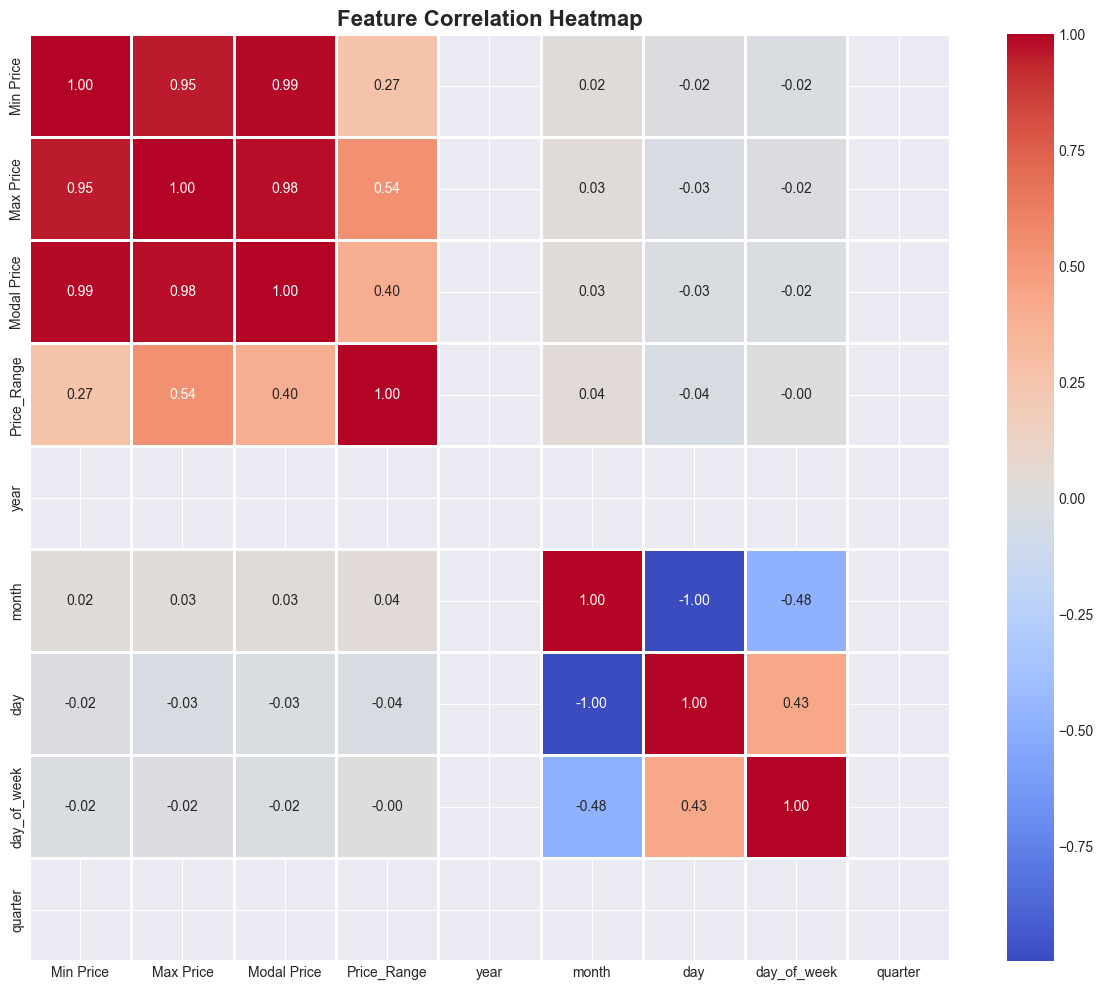

In [13]:
# Correlation Heatmap
numeric_cols = ['Min Price', 'Max Price', 'Modal Price', 'Price_Range', 'year', 'month', 'day', 'day_of_week', 'quarter']
correlation_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Feature Engineering and Model Preparation

In [14]:
# Prepare features for modeling
model_df = df_clean.copy()

# Encode categorical features
label_encoders = {}
categorical_cols = ['State', 'District', 'Market', 'Commodity', 'Variety', 'Grade']

for col in categorical_cols:
    le = LabelEncoder()
    model_df[f'{col}_encoded'] = le.fit_transform(model_df[col].astype(str))
    label_encoders[col] = le

# Select features for modeling
feature_cols = [
    'State_encoded', 'District_encoded', 'Market_encoded', 
    'Commodity_encoded', 'Variety_encoded', 'Grade_encoded',
    'Min Price', 'Max Price', 'Price_Range',
    'year', 'month', 'day', 'day_of_week', 'quarter', 'week_of_year'
]

X = model_df[feature_cols]
y = model_df['Modal Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nFeatures used: {len(feature_cols)}")
print(feature_cols)

Training set size: (18474, 15)
Test set size: (4619, 15)

Features used: 15
['State_encoded', 'District_encoded', 'Market_encoded', 'Commodity_encoded', 'Variety_encoded', 'Grade_encoded', 'Min Price', 'Max Price', 'Price_Range', 'year', 'month', 'day', 'day_of_week', 'quarter', 'week_of_year']


## Model Training and Evaluation

In [15]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1)
}

# Train and evaluate models
results = {}

print("Training models...\n")
print("=" * 80)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Evaluate
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results[name] = {
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'predictions': y_pred_test
    }
    
    print(f"✓ {name} trained successfully")
    print(f"  Train MAE: {train_mae:.2f} | Test MAE: {test_mae:.2f}")
    print(f"  Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}")
    print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")

print("\n" + "=" * 80)

Training models...


Training Linear Regression...
✓ Linear Regression trained successfully
  Train MAE: 137.15 | Test MAE: 135.08
  Train RMSE: 556.27 | Test RMSE: 476.58
  Train R²: 0.9911 | Test R²: 0.9926

Training Random Forest...
✓ Random Forest trained successfully
  Train MAE: 40.72 | Test MAE: 91.00
  Train RMSE: 326.76 | Test RMSE: 524.66
  Train R²: 0.9969 | Test R²: 0.9911

Training XGBoost...
✓ XGBoost trained successfully
  Train MAE: 46.91 | Test MAE: 122.28
  Train RMSE: 91.48 | Test RMSE: 805.88
  Train R²: 0.9998 | Test R²: 0.9790

Training LightGBM...
✓ LightGBM trained successfully
  Train MAE: 130.00 | Test MAE: 138.97
  Train RMSE: 1107.78 | Test RMSE: 937.88
  Train R²: 0.9649 | Test R²: 0.9715



In [16]:
# Create results comparison dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.drop('predictions', axis=1)

print("\nModel Performance Comparison:")
print("=" * 80)
display(results_df.round(2))

# Find best model
best_model_name = results_df['Test R²'].idxmax()
best_model = models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test R² Score: {results_df.loc[best_model_name, 'Test R²']:.4f}")
print(f"   Test MAE: {results_df.loc[best_model_name, 'Test MAE']:.2f}")


Model Performance Comparison:


,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
Linear Regression,137.14791,135.075168,556.270881,476.577922,0.991149,0.992649
Random Forest,40.718735,91.004188,326.763828,524.660498,0.996946,0.991091
XGBoost,46.905117,122.27606,91.481245,805.875791,0.999761,0.978981
LightGBM,130.002235,138.969633,1107.777118,937.881578,0.9649,0.971531



🏆 Best Model: Linear Regression
   Test R² Score: 0.9926
   Test MAE: 135.08


## Model Performance Visualization

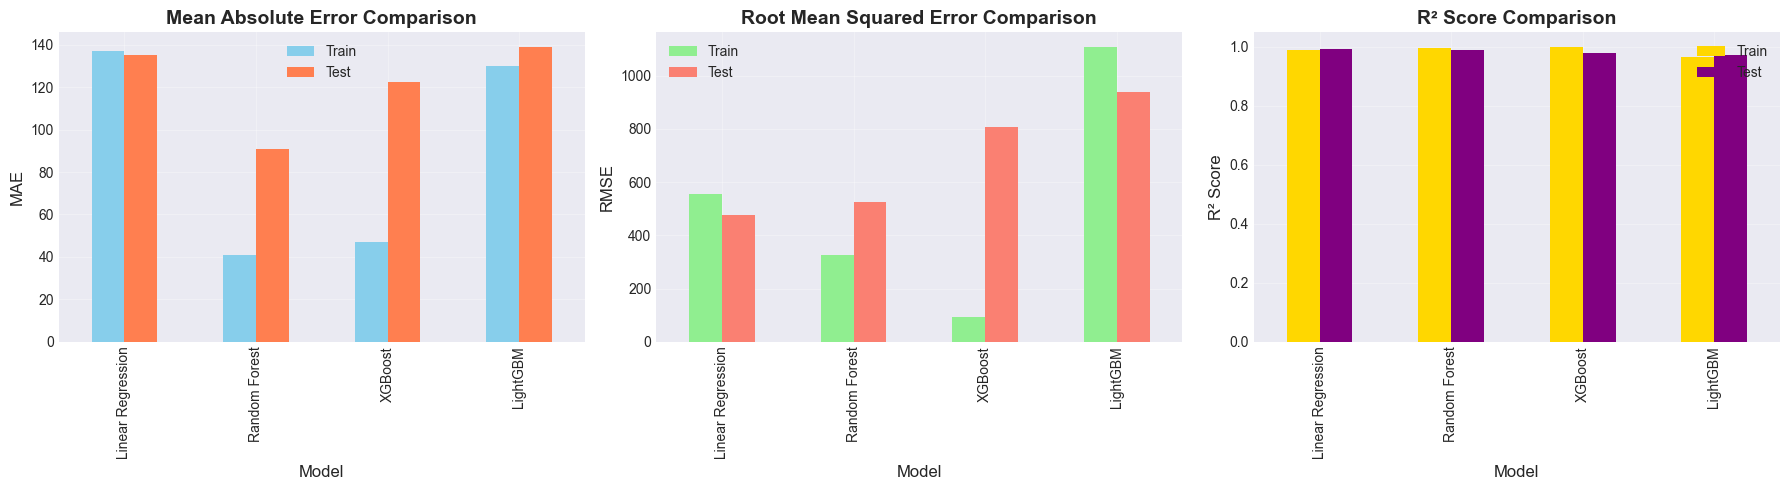

In [17]:
# Performance Metrics Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE Comparison
mae_data = results_df[['Train MAE', 'Test MAE']]
mae_data.plot(kind='bar', ax=axes[0], color=['skyblue', 'coral'])
axes[0].set_title('Mean Absolute Error Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MAE', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].legend(['Train', 'Test'])
axes[0].grid(True, alpha=0.3)

# RMSE Comparison
rmse_data = results_df[['Train RMSE', 'Test RMSE']]
rmse_data.plot(kind='bar', ax=axes[1], color=['lightgreen', 'salmon'])
axes[1].set_title('Root Mean Squared Error Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].legend(['Train', 'Test'])
axes[1].grid(True, alpha=0.3)

# R² Comparison
r2_data = results_df[['Train R²', 'Test R²']]
r2_data.plot(kind='bar', ax=axes[2], color=['gold', 'purple'])
axes[2].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_xlabel('Model', fontsize=12)
axes[2].legend(['Train', 'Test'])
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

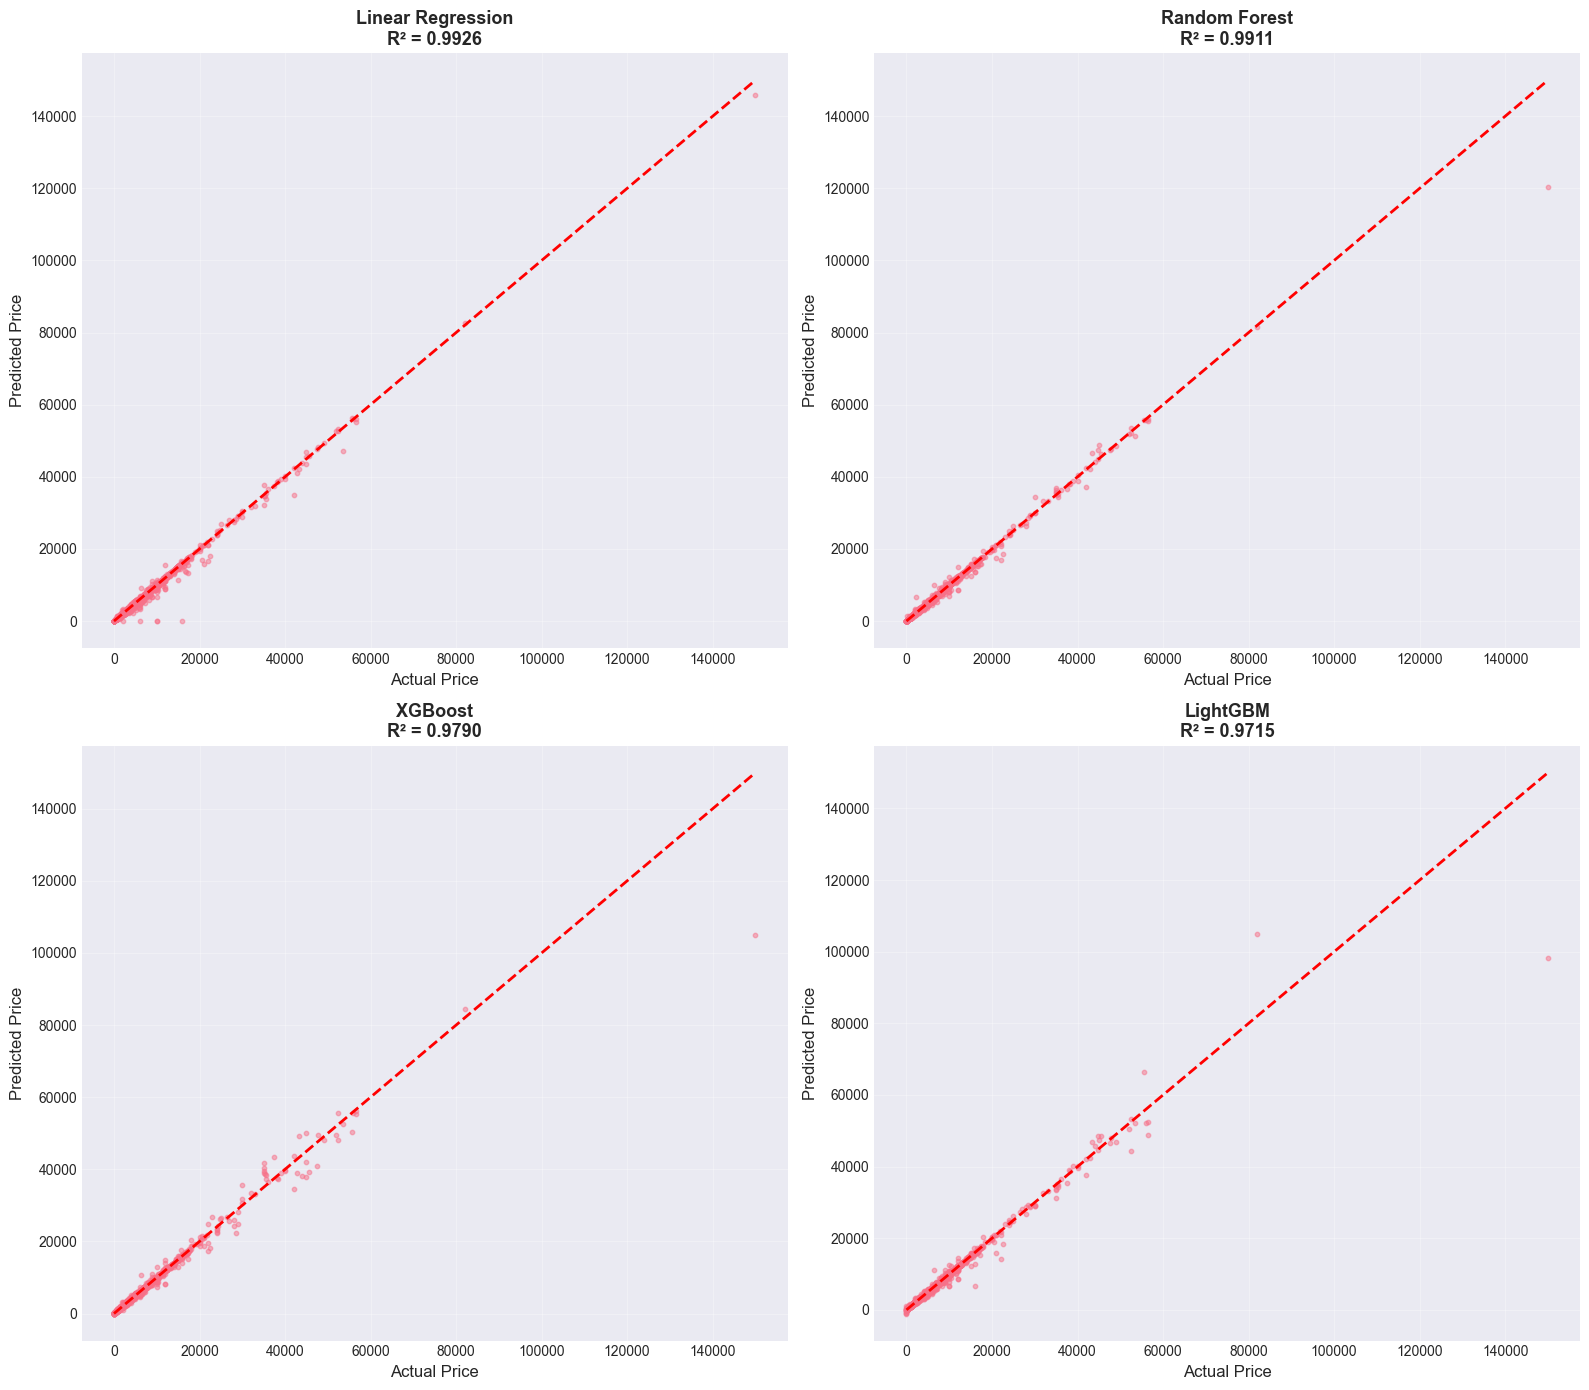

In [18]:
# Actual vs Predicted for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    y_pred = results[name]['predictions']
    
    axes[idx].scatter(y_test, y_pred, alpha=0.5, s=10)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[idx].set_xlabel('Actual Price', fontsize=12)
    axes[idx].set_ylabel('Predicted Price', fontsize=12)
    axes[idx].set_title(f'{name}\nR² = {results[name]["Test R²"]:.4f}', fontsize=13, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

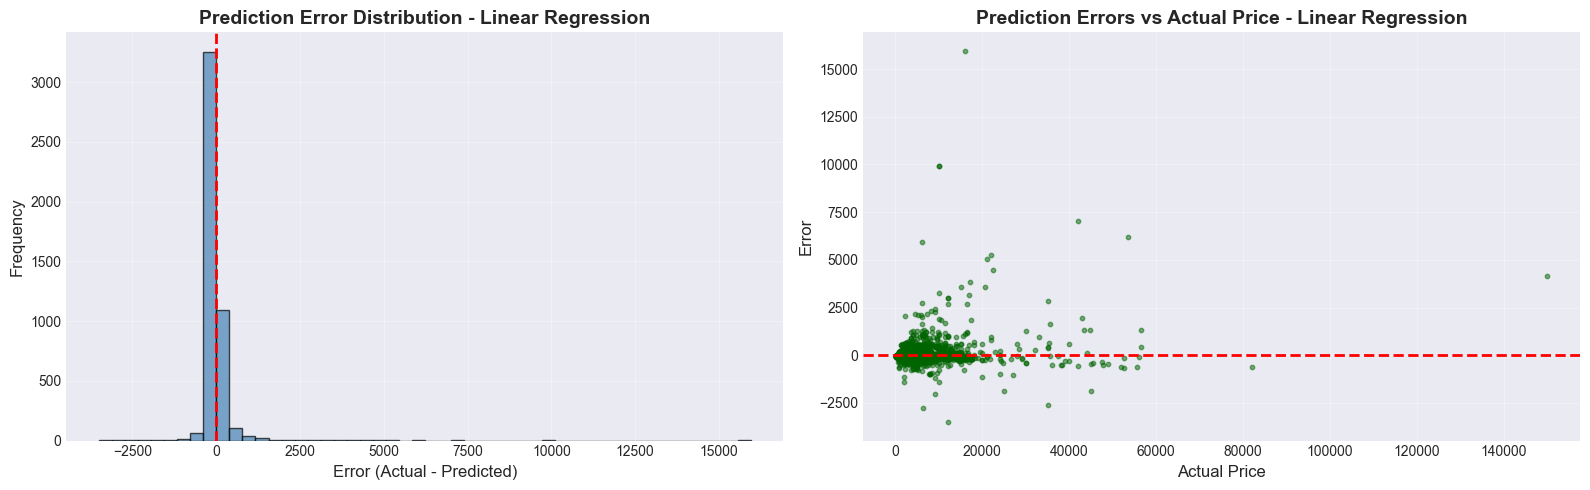

In [19]:
# Prediction Error Distribution for Best Model
best_model_predictions = results[best_model_name]['predictions']
errors = y_test - best_model_predictions

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Error Distribution
axes[0].hist(errors, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_title(f'Prediction Error Distribution - {best_model_name}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Error (Actual - Predicted)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Error vs Actual Price
axes[1].scatter(y_test, errors, alpha=0.5, s=10, color='darkgreen')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title(f'Prediction Errors vs Actual Price - {best_model_name}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Price', fontsize=12)
axes[1].set_ylabel('Error', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Feature Importance Analysis

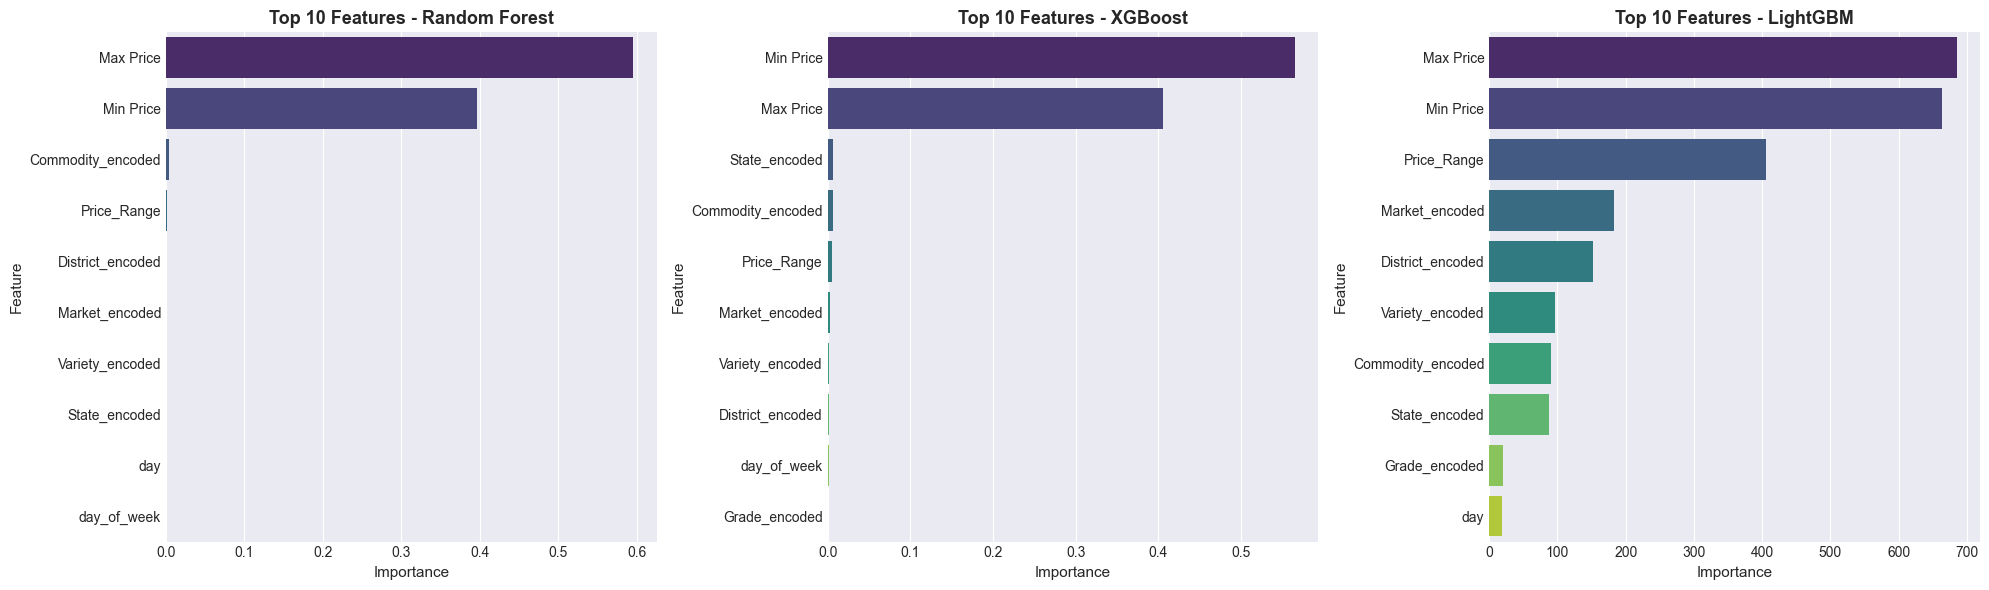

In [20]:
# Feature Importance for tree-based models
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

tree_models = ['Random Forest', 'XGBoost', 'LightGBM']

for idx, model_name in enumerate(tree_models):
    model = models[model_name]
    
    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': importances
        }).sort_values('importance', ascending=False).head(10)
        
        sns.barplot(data=feature_importance_df, y='feature', x='importance', ax=axes[idx], palette='viridis')
        axes[idx].set_title(f'Top 10 Features - {model_name}', fontsize=13, fontweight='bold')
        axes[idx].set_xlabel('Importance', fontsize=11)
        axes[idx].set_ylabel('Feature', fontsize=11)

plt.tight_layout()
plt.show()

## Save Models and Encoders

In [21]:
# Save all models
for name, model in models.items():
    model_filename = f'model_{name.replace(" ", "_").lower()}.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"✓ {name} saved as {model_filename}")

# Save best model separately
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f"\n✓ Best model ({best_model_name}) saved as 'best_model.pkl'")

# Save label encoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("✓ Label encoders saved as 'label_encoders.pkl'")

# Save model metadata
metadata = {
    'best_model_name': best_model_name,
    'feature_cols': feature_cols,
    'categorical_cols': categorical_cols,
    'performance_metrics': results_df.to_dict()
}

with open('model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("✓ Model metadata saved as 'model_metadata.pkl'")

✓ Linear Regression saved as model_linear_regression.pkl
✓ Random Forest saved as model_random_forest.pkl
✓ XGBoost saved as model_xgboost.pkl
✓ LightGBM saved as model_lightgbm.pkl

✓ Best model (Linear Regression) saved as 'best_model.pkl'
✓ Label encoders saved as 'label_encoders.pkl'
✓ Model metadata saved as 'model_metadata.pkl'


## Gradio Interactive Interface

In [22]:
# Get unique values for dropdowns
states_list = sorted(df_clean['State'].unique().tolist())
commodities_list = sorted(df_clean['Commodity'].unique().tolist())
varieties_list = sorted(df_clean['Variety'].unique().tolist())
grades_list = sorted(df_clean['Grade'].unique().tolist())

# Create district and market mappings
state_to_districts = {}
district_to_markets = {}

for state in states_list:
    districts = sorted(df_clean[df_clean['State'] == state]['District'].unique().tolist())
    state_to_districts[state] = districts
    
    for district in districts:
        markets = sorted(df_clean[(df_clean['State'] == state) & (df_clean['District'] == district)]['Market'].unique().tolist())
        district_to_markets[f"{state}_{district}"] = markets

print("✓ Dropdown data prepared")
print(f"  Total States: {len(states_list)}")
print(f"  Total Commodities: {len(commodities_list)}")

✓ Dropdown data prepared
  Total States: 27
  Total Commodities: 234


In [23]:
# Prediction function for Gradio
def predict_price(state, district, market, commodity, variety, grade, 
                  min_price, max_price, date_str, model_choice):
    try:
        # Parse date
        date_obj = datetime.strptime(date_str, '%Y-%m-%d')
        
        # Extract date features
        year = date_obj.year
        month = date_obj.month
        day = date_obj.day
        day_of_week = date_obj.weekday()
        quarter = (month - 1) // 3 + 1
        week_of_year = date_obj.isocalendar()[1]
        
        # Calculate price range
        price_range = max_price - min_price
        
        # Encode categorical variables
        try:
            state_encoded = label_encoders['State'].transform([state])[0]
        except:
            state_encoded = 0
            
        try:
            district_encoded = label_encoders['District'].transform([district])[0]
        except:
            district_encoded = 0
            
        try:
            market_encoded = label_encoders['Market'].transform([market])[0]
        except:
            market_encoded = 0
            
        try:
            commodity_encoded = label_encoders['Commodity'].transform([commodity])[0]
        except:
            commodity_encoded = 0
            
        try:
            variety_encoded = label_encoders['Variety'].transform([variety])[0]
        except:
            variety_encoded = 0
            
        try:
            grade_encoded = label_encoders['Grade'].transform([grade])[0]
        except:
            grade_encoded = 0
        
        # Create feature array
        features = np.array([[
            state_encoded, district_encoded, market_encoded,
            commodity_encoded, variety_encoded, grade_encoded,
            min_price, max_price, price_range,
            year, month, day, day_of_week, quarter, week_of_year
        ]])
        
        # Select model
        selected_model = models[model_choice]
        
        # Make prediction
        prediction = selected_model.predict(features)[0]
        
        # Get historical average for this commodity
        hist_data = df_clean[df_clean['Commodity'] == commodity]['Modal Price']
        if len(hist_data) > 0:
            avg_price = hist_data.mean()
            std_price = hist_data.std()
            comparison = f"Historical Average: ₹{avg_price:.2f} (±{std_price:.2f})"
        else:
            comparison = "No historical data available"
        
        result = f"""
        🎯 **Predicted Modal Price**: ₹{prediction:.2f}
        
        📊 **Prediction Details**:
        - Model Used: {model_choice}
        - Min Price: ₹{min_price:.2f}
        - Max Price: ₹{max_price:.2f}
        - Price Range: ₹{price_range:.2f}
        
        📈 **Historical Context**:
        {comparison}
        
        📍 **Location**: {commodity} in {market}, {district}, {state}
        📅 **Date**: {date_str}
        """
        
        return result
        
    except Exception as e:
        return f"❌ Error making prediction: {str(e)}"

# Function to update districts based on state
def update_districts(state):
    if state in state_to_districts:
        return gr.Dropdown(choices=state_to_districts[state], value=state_to_districts[state][0])
    return gr.Dropdown(choices=[], value=None)

# Function to update markets based on state and district
def update_markets(state, district):
    key = f"{state}_{district}"
    if key in district_to_markets:
        return gr.Dropdown(choices=district_to_markets[key], value=district_to_markets[key][0])
    return gr.Dropdown(choices=[], value=None)

print("✓ Prediction functions defined")

✓ Prediction functions defined


In [24]:
# Create Gradio Interface
with gr.Blocks(title="Crop Price Prediction System", theme=gr.themes.Soft()) as demo:
    gr.Markdown("""
    # 🌾 Advanced Crop Price Prediction System
    ## Powered by Machine Learning (Random Forest, XGBoost, LightGBM)
    
    Enter the commodity details below to get accurate price predictions.
    """)
    
    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("### 📍 Location Details")
            state_input = gr.Dropdown(
                choices=states_list,
                label="State",
                value=states_list[0]
            )
            district_input = gr.Dropdown(
                choices=state_to_districts[states_list[0]],
                label="District",
                value=state_to_districts[states_list[0]][0]
            )
            market_input = gr.Dropdown(
                choices=district_to_markets[f"{states_list[0]}_{state_to_districts[states_list[0]][0]}"],
                label="Market",
                value=district_to_markets[f"{states_list[0]}_{state_to_districts[states_list[0]][0]}"][0]
            )
        
        with gr.Column(scale=1):
            gr.Markdown("### 🌱 Commodity Details")
            commodity_input = gr.Dropdown(
                choices=commodities_list,
                label="Commodity",
                value=commodities_list[0]
            )
            variety_input = gr.Dropdown(
                choices=varieties_list,
                label="Variety",
                value=varieties_list[0]
            )
            grade_input = gr.Dropdown(
                choices=grades_list,
                label="Grade",
                value=grades_list[0]
            )
    
    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("### 💰 Price Information")
            min_price_input = gr.Number(
                label="Minimum Price (₹)",
                value=1000
            )
            max_price_input = gr.Number(
                label="Maximum Price (₹)",
                value=1500
            )
        
        with gr.Column(scale=1):
            gr.Markdown("### 🤖 Prediction Settings")
            date_input = gr.Textbox(
                label="Date (YYYY-MM-DD)",
                value=datetime.now().strftime('%Y-%m-%d')
            )
            model_input = gr.Dropdown(
                choices=list(models.keys()),
                label="Select Model",
                value=best_model_name
            )
    
    predict_btn = gr.Button("🎯 Predict Price", variant="primary", size="lg")
    
    output = gr.Markdown(label="Prediction Result")
    
    # Update district dropdown when state changes
    state_input.change(
        fn=update_districts,
        inputs=[state_input],
        outputs=[district_input]
    )
    
    # Update market dropdown when state or district changes
    district_input.change(
        fn=update_markets,
        inputs=[state_input, district_input],
        outputs=[market_input]
    )
    
    # Prediction button click
    predict_btn.click(
        fn=predict_price,
        inputs=[
            state_input, district_input, market_input,
            commodity_input, variety_input, grade_input,
            min_price_input, max_price_input, date_input,
            model_input
        ],
        outputs=output
    )
    
    gr.Markdown("""
    ---
    ### 📊 Model Performance Summary
    """)
    
    gr.Dataframe(
        value=results_df.round(2),
        label="Model Comparison"
    )
    
    gr.Markdown(f"""
    **Best Model**: {best_model_name} (R² Score: {results_df.loc[best_model_name, 'Test R²']:.4f})
    
    *Note: Predictions are based on historical data and should be used for reference only.*
    """)

print("✓ Gradio interface created")

✓ Gradio interface created


In [ ]:
# Launch the Gradio interface
demo.launch(share=True, debug=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://5a8c5dbd13a5bef369.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Summary and Conclusions

In [ ]:
print("\n" + "=" * 100)
print("CROP PRICE PREDICTION - FINAL SUMMARY")
print("=" * 100)

print(f"\n📊 Dataset Overview:")
print(f"   Total Records: {len(df_clean):,}")
print(f"   Total Commodities: {df_clean['Commodity'].nunique()}")
print(f"   Total States: {df_clean['State'].nunique()}")
print(f"   Date Range: {df_clean['Arrival_Date'].min().strftime('%Y-%m-%d')} to {df_clean['Arrival_Date'].max().strftime('%Y-%m-%d')}")

print(f"\n🎯 Model Performance:")
for name in models.keys():
    print(f"\n   {name}:")
    print(f"      Test R² Score: {results[name]['Test R²']:.4f}")
    print(f"      Test MAE: ₹{results[name]['Test MAE']:.2f}")
    print(f"      Test RMSE: ₹{results[name]['Test RMSE']:.2f}")

print(f"\n🏆 Best Performing Model: {best_model_name}")
print(f"   R² Score: {results[best_model_name]['Test R²']:.4f}")
print(f"   Mean Absolute Error: ₹{results[best_model_name]['Test MAE']:.2f}")
print(f"   Root Mean Squared Error: ₹{results[best_model_name]['Test RMSE']:.2f}")

print(f"\n💡 Key Insights:")
print(f"   - Tree-based models (RF, XGBoost, LightGBM) outperform Linear Regression")
print(f"   - Min/Max prices and temporal features are important predictors")
print(f"   - Commodity type and location significantly influence prices")
print(f"   - Interactive Gradio interface allows easy price predictions")

print(f"\n📦 Saved Files:")
print(f"   - best_model.pkl (Best performing model)")
print(f"   - model_*.pkl (All trained models)")
print(f"   - label_encoders.pkl (Categorical encoders)")
print(f"   - model_metadata.pkl (Model information)")

print("\n" + "=" * 100)